In [1]:
import pandas as pd
from pandas_datareader import data as wb
import numpy as np
import quandl
from pandas import ExcelWriter
import matplotlib.pyplot as plt
from arch import arch_model
from scipy.stats import t
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats as scipy_stats
import statsmodels.api as sm
rf = quandl.get("USTREASURY/YIELD")['1 YR']
rf = rf.loc['1995-01-01':].resample('1W').last()[1:]/100
rf = pd.DataFrame(rf)

In [2]:
Ticker=['SPY']
print(Ticker,len(Ticker))
df=pd.DataFrame()
for i in Ticker:
    df[i]=wb.DataReader(i,'yahoo', start='1995-01-01')['Adj Close']
sp500 = df.resample('1W').last().pct_change().dropna()
sp500.columns = ['SP500']

['SPY'] 1


In [3]:
class TIPP:
    
    def __init__(self,returns,safe_asset_rate,Lock_in,Min_risk_part,Capital_reinjection_rate,cppi,floor_percent,m):
            self.returns = returns
            self.safe_asset_rate = safe_asset_rate
            self.Lock_in = Lock_in
            self.Min_risk_part = Min_risk_part
            self.Capital_reinjection_rate = Capital_reinjection_rate
            self.cppi = cppi
            self.floor_percent = floor_percent
            self.m = m
            self.tppi = self.tipp(returns,safe_asset_rate,Lock_in,Min_risk_part,Capital_reinjection_rate,cppi,floor_percent,m)
            
    def tipp(self,returns,safe_asset_rate,Lock_in,Min_risk_part,Capital_reinjection_rate,cppi,floor_percent,m):
        
        goal = len(returns.index)/52
        safe_assets = pd.DataFrame().reindex_like(returns)
        Year_rf = safe_asset_rate
        safe_assets[:] = safe_asset_rate / 52
        #Initial portfolio value
        CPPI = cppi
        # This is the minimum value I want to preserve
        F = CPPI * floor_percent/((1+Year_rf.iloc[0,0])**goal)
    
        Reference_cap = CPPI

        CPPI_values = pd.DataFrame().reindex_like(returns)
        floor_values = pd.DataFrame().reindex_like(returns)
        reference_cap = pd.DataFrame().reindex_like(returns)
        Capital_reinjection = pd.DataFrame().reindex_like(returns)
        floor_values[:] = F
        CPPI_max = CPPI
        for i in range(len(returns.index)):
            if CPPI > (1+Lock_in)*Reference_cap:
                Reference_cap = CPPI
                reference_cap.iloc[i] = CPPI
            else :
                reference_cap.iloc[i] = Reference_cap
            
            F_updated = CPPI * floor_percent/((1+Year_rf.iloc[i,0])**(goal))  #CPPI * floor_percent , Update floor Cap or no?
        
            if F < F_updated: # Floor Capital
                F = F_updated
            
            if CPPI<Reference_cap*Capital_reinjection_rate: #Capital Reinjection 
                Dif_CPPI_F = Reference_cap*Capital_reinjection_rate - CPPI
                Reference_cap = Reference_cap - Dif_CPPI_F
                reference_cap.iloc[i] = Reference_cap
                CPPI  = CPPI + Dif_CPPI_F 
                Capital_reinjection.iloc[i] = Dif_CPPI_F
            else : 
                Capital_reinjection.iloc[i] = 0
    
            
            C = CPPI - F
            risky_asset_e = max(min(m * C, CPPI),Min_risk_part*CPPI) 
            risklet_asset = CPPI - risky_asset_e
            CPPI = risky_asset_e * (1 + returns.iloc[i].item()) + risklet_asset * (1 + safe_assets.iloc[i].item())
            CPPI_values.iloc[i] = CPPI
            floor_values.iloc[i] = F
            goal = goal - 1/52
            
        CPPI_values.columns = ['TIPP Strategy']
        
        return CPPI_values, floor_values,Capital_reinjection,reference_cap 
    
class Chart:
    
    def Chart(self,returns,tipp,floor_values,ref_cap,reinjection_cap,DD,Actualized_Var,Actualized_Expected_Shortfall,Cst_VaR):
        
        fig,axe=plt.subplots()
        
        chart = tipp.plot(ax=axe,figsize=(12,6), color="blue", legend=True)
        
        normal =  tipp.iloc[0,0]*(1+returns).cumprod()
        
        normal.columns = ['Benchmark']
        
        normal.plot(ax=axe, style='g--', legend=True)
        
        floor_values.plot(ax=axe, style='red', legend=True)
        
        ref_cap.plot(ax=axe, style='black', legend=True)
        
        #reinjection_cap.plot(ax=axe, style='b--', legend=True)
        ax2=axe.twinx()
        
        reinjection_cap.plot(ax=ax2, style='b--', legend=True)
        
        # make a plot with different y-axis using second axis object
        #ax2.plot(reinjection_cap,color="red",marker="o")
        
        ax2.set_ylabel(" Capital Reinjection amount ",color="Black",fontsize=14)
        
        axe.set_ylabel(" Cumulative Amount ",color="Black",fontsize=14)
        
        axe.legend(['With TIPP','Without TIPP','Floor','Reference Capital'])
        
        ax2.legend(['Capital Reinjection'])
        
        plt.show()
        
        fig,axe2=plt.subplots()
        
        B_Drawdown = (normal.div(normal.cummax())-1)*100
        
        B_Drawdown.columns = ['Benchmark Drawdown in (%)']
        
        DD.plot(ax=axe2,figsize=(12,6), legend=True)
        
        B_Drawdown.plot(ax=axe2,figsize=(12,6), legend=True)
        
        plt.show()
        
        fig3,axe3=plt.subplots()
        
        Actualized_Var.plot(ax=axe3,style='g--',figsize=(12,6),legend = True)
        
        Actualized_Expected_Shortfall.plot(ax=axe3,style='red',legend = True)
        
        Cst_VaR.plot(ax=axe3,style='black',legend = True)
        
        plt.show()
        
    def __init__(self,returns,tipp,floor_values,ref_cap,reinjection_cap,DD,Actualized_Var,Actualized_Expected_Shortfall,Cst_VaR):
        self.returns = returns
        self.tipp = tipp
        self.floor_values =floor_values
        self.ref_cap = ref_cap
        self.reinjection_cap = reinjection_cap
        self.Actualized_Var = Actualized_Var
        self.Actualized_Expected_Shortfall = Actualized_Expected_Shortfall
        self.Cst_VaR = Cst_VaR
        self.Charting = self.Chart(returns,tipp,floor_values,ref_cap,reinjection_cap,DD,Actualized_Var,Actualized_Expected_Shortfall,Cst_VaR)
        
class Registration :
    
    def Register(self,returns,CPPI_values, floor_values,Capital_reinjection,reference_cap,safe_asset_rate,days,DD,Omega_r,Sharp_ratio,Sortino_ratio,information_ratio,M2_Ratio,PSR,CGR,STD,Cst_VaR,Actualized_Expected_Shortfall,Actualized_Var,Beta,jensen_alpha,Max_drawdown,cum_returns):       
        
        exportList=pd.DataFrame({'Benchmark':CPPI_values.iloc[0,0]*(1+returns).cumprod().iloc[:,0],'TPPI':CPPI_values.iloc[:,0], "Floor":floor_values.iloc[:,0],"Reference Capital":reference_cap.iloc[:,0],"Capital reinjection":Capital_reinjection.iloc[:,0]
                                 ,"Drawdowns":DD.iloc[:,0]}
                                ,index = reference_cap.index).fillna(0)

        
        exportList2 = pd.DataFrame({"Actualized VaR 5%":Actualized_Var.iloc[:,0],"Actualized Expected Shortfall 5%":Actualized_Expected_Shortfall.iloc[:,0],"Constant VaR 5%":Cst_VaR.iloc[:,0]},index = Actualized_Var.index)
        
        exportList3 = pd.DataFrame({"Sharpe Ratio":Sharp_ratio,"Omega Ratio":Omega_r,"Sortino_ratio":Sortino_ratio,"Information Ratio":information_ratio,"Modigliani Ratio":M2_Ratio,"Probabilistic Sharpe Ratio":PSR,"CAGR":CGR,"Standard deviation":STD,"Beta":Beta,"Jensen alpha":jensen_alpha,"Maximum Drawdown(in %)":Max_drawdown,"Cumulative Returns(in %)":cum_returns},index = ["Ratios"])
        
        writer = ExcelWriter("ScreenOutput.xlsx")
        exportList.to_excel(writer, "Strategy") #Sheet1
        workbook = writer.book
        worksheet = writer.sheets['Strategy']
        chart = workbook.add_chart({'type': 'line'})
        max_row = len(exportList) + 1
        for i in range(len(exportList.columns[:-1])):
            col = i + 1
            chart.add_series({
                'name':       ['Strategy', 0, col],
                'categories': ['Strategy', 1, 0, max_row, 0],
                'values':     ['Strategy', 1, col, max_row, col],
                'line':       {'width': 1.00},
            })
        # Configure the chart axes.
        chart.set_x_axis({'name': 'Date', 'date_axis': True})
        chart.set_y_axis({'name': 'Amount (in M$)', 'major_gridlines': {'visible': False}})
            
        # Position the legend at the top of the chart.
        chart.set_legend({'position': 'top'})
            
        # Insert the chart into the worksheet.
        worksheet.insert_chart('J2', chart)
        
        chart2 = workbook.add_chart({'type': 'line'})
        max_row = len(exportList) + 1
        for i in range(len(['reinjection'])):
            col = i + 5
            chart2.add_series({
                'name':       ['Strategy', 0, col],
                'categories': ['Strategy', 1, 0, max_row, 0],
                'values':     ['Strategy', 1, col, max_row, col],
                'line':       {'width': 1.00},
            })
        # Configure the chart axes.
        chart2.set_x_axis({'name': 'Date', 'date_axis': True})
        chart2.set_y_axis({'name': 'Amount (in M$)', 'major_gridlines': {'visible': False}})
            
        # Position the legend at the top of the chart.
        chart2.set_legend({'position': 'top'})
            
        # Insert the chart into the worksheet.
        worksheet.insert_chart('X2', chart2)
        
        chart3 = workbook.add_chart({'type': 'line'})
        max_row = len(exportList) + 1
        for i in range(len(['DD'])):
            col = i + 6
            chart3.add_series({
                'name':       ['Strategy', 0, col],
                'categories': ['Strategy', 1, 0, max_row, 0],
                'values':     ['Strategy', 1, col, max_row, col],
                'line':       {'width': 1.00},
            })
            
        # Configure the chart axes.
        chart3.set_x_axis({'name': 'Date', 'date_axis': True})
        chart3.set_y_axis({'name': 'In %', 'major_gridlines': {'visible': False}})
            
        # Position the legend at the top of the chart.
        chart3.set_legend({'position': 'top'})
            
        # Insert the chart into the worksheet.
        worksheet.insert_chart('J25', chart3)
        
        exportList2.to_excel(writer, "Risk Management")
        workbook = writer.book
        worksheet = writer.sheets['Risk Management']
        chart_var = workbook.add_chart({'type': 'line'})
        max_row = len(exportList2) + 1
        for i in range(len(exportList2.columns)):
            col = i + 1
            chart_var.add_series({
                'name':       ['Risk Management', 0, col],
                'categories': ['Risk Management', 1, 0, max_row, 0],
                'values':     ['Risk Management', 1, col, max_row, col],
                'line':       {'width': 1.00},
            })
        # Configure the chart axes.
        chart_var.set_x_axis({'name': 'Date', 'date_axis': True})
        chart_var.set_y_axis({'name': 'in %', 'major_gridlines': {'visible': False}})
            
        # Position the legend at the top of the chart.
        chart_var.set_legend({'position': 'top'})
            
        # Insert the chart into the worksheet.
        worksheet.insert_chart('G2', chart_var)
        
        exportList3.to_excel(writer, "Ratios")
        workbook = writer.book
        worksheet = writer.sheets['Ratios']
        chart_ratios = workbook.add_chart({'type': 'line'})
        max_row = len(exportList3) + 1
        for i in range(len(exportList3.columns[:-1])):
            col = i + 1
            chart_ratios.add_series({
                'name':       ['Ratios', 0, col],
                'categories': ['Ratios', 1, 0, max_row, 0],
                'values':     ['Ratios', 1, col, max_row, col],
                'line':       {'width': 1.00},
            })
        
        writer.save()
        
        print("Your document is registred under the name:'ScreenOutput.xlsx'")
        
        return 
    
    def __init__(self,returns,CPPI_values,floor_values,Capital_reinjection,reference_cap,safe_asset_rate,days,DD,Omega_r,Sharp_ratio,Sortino_ratio,information_ratio,M2_Ratio,PSR,CGR,STD,Cst_VaR,Actualized_Expected_Shortfall,Actualized_Var,Beta,jensen_alpha,Max_drawdown,cum_returns):
        self.returns = returns
        self.CPPI_values = CPPI_values
        self.floor_values =floor_values
        self.reference_cap = reference_cap
        self.Capital_reinjection = Capital_reinjection
        self.DD = DD
        self.Omega_r = Omega_r
        self.Sharp_ratio = Sharp_ratio
        self.Sortino_ratio = Sortino_ratio
        self.information_ratio = information_ratio
        self.M2_Ratio = M2_Ratio
        self.PSR = PSR
        self.days = days
        self.Cst_VaR = Cst_VaR
        self.CGR = CGR
        self.STD = STD
        self.Actualized_Expected_Shortfall = Actualized_Expected_Shortfall
        self.Actualized_Var = Actualized_Var
        self.Beta = Beta
        self.jensen_alpha = jensen_alpha
        self.Max_drawdown = Max_drawdown
        self.cum_returns = cum_returns
        self.Registering = self.Register(returns,CPPI_values, floor_values,Capital_reinjection,reference_cap,safe_asset_rate,days,DD,Omega_r,Sharp_ratio,Sortino_ratio,information_ratio,M2_Ratio,PSR,CGR,STD,Cst_VaR,Actualized_Expected_Shortfall,Actualized_Var,Beta,jensen_alpha,Max_drawdown,cum_returns)     


In [4]:
class Initializing_values:
    
    def __init__(self):
        pass
            
    def Charted(self,breturns, A, B,C,D,VaR_C,CvaR_D,VaR_unc):
        E = self.DD(A.pct_change())
        Chart(breturns,A,B,D,C,E,VaR_C,CvaR_D,VaR_unc).Charting
        
    def Values(self,breturns,safe_asset_rate,Lock_in,Min_risk_part,Capital_reinjection_rate,cppi,floor_percent,m):
        A, B,C,D = TIPP(breturns,safe_asset_rate,Lock_in,Min_risk_part,Capital_reinjection_rate,cppi,floor_percent,m).tppi
        return A,B,C,D
    
    def Rgstr(self,breturns,CPPI_values, floor_values,Capital_reinjection,reference_cap,safe_asset_rate,days,theta,sampled_garch_number_needed):
        
        returns = CPPI_values.pct_change()
        
        cum_returns = self.Cumulative_r(returns)*100
        
        E = self.DD(returns)
        
        Omega_r = self.Omega_ratio(returns)
        
        Sharp_ratio = self.Sharp_rt(returns,safe_asset_rate,days)
        
        Sortino_ratio = self.Sortino_rt(returns,safe_asset_rate,days)
        
        information_ratio = self.information_ratio(returns,breturns,days)
        
        M2_Ratio = self.modigliani_ratio(returns,breturns,safe_asset_rate,days)
        
        PSR = self.probabilistic_sharpe_ratio(returns,breturns,safe_asset_rate,days)
        
        CGR = self.CAGR(returns)
        
        STD = self.STD(returns,days)
        
        Actualized_Var,Actualized_Expected_Shortfall,Cst_VaR = self.VaR_Studen_Distribution(returns,theta,sampled_garch_number_needed)
        
        Beta,jensen_alpha= Initializing_values().jensen_alpha_beta(returns ,Risk_ass,days=52)
        
        Max_drawdown = E.min()[0]
        
        Registration(breturns,CPPI_values, floor_values,Capital_reinjection,reference_cap,safe_asset_rate,days,E,Omega_r,Sharp_ratio,Sortino_ratio,information_ratio,M2_Ratio,PSR,CGR,STD,Cst_VaR,Actualized_Expected_Shortfall,Actualized_Var,Beta,jensen_alpha,Max_drawdown,cum_returns).Registering
        
        return 
    
    def Sharp_rt(self,returns,safe_asset_rate,days):
        Excess_returns = ((returns- safe_asset_rate.values/days).mean()*days)
        strat_std = returns.std()*np.sqrt(days)
        Sharpe_ratio = (Excess_returns/strat_std)[0]
        return Sharpe_ratio
                          
    def Sortino_rt(self,returns,safe_asset_rate,days):
        Sortino_std = returns.mask(returns>=0).std()*np.sqrt(days)
        Excess_returns = ((returns- safe_asset_rate.values/days).mean()*days)
        Sortino_ratio = (Excess_returns/Sortino_std)[0]
        return Sortino_ratio
                          
                          
    def information_ratio(self,returns, breturns, days):
        return_difference = returns - breturns.values
        volatility = return_difference.std() * np.sqrt(days)
        information_ratio = ((return_difference.mean()*days) / volatility)[0]
        return information_ratio
    
    def modigliani_ratio(self,returns, breturns, safe_asset_rate, days):
        #volatility = returns.std() * np.sqrt(days)
        sharpe_ratio = self.Sharp_rt(returns,safe_asset_rate,days)#(returns.mean() - rf) / volatility
        benchmark_volatility = breturns.std() * np.sqrt(days)
        m2_ratio = ((sharpe_ratio * benchmark_volatility)[0] + safe_asset_rate.iloc[-1])[0]
        return m2_ratio
    
    def estimated_sharpe_ratio_stdev(self,returns,safe_asset_rate,days):
        sharpe_ratio = self.Sharp_rt(returns,safe_asset_rate,days)
        n = len(returns)
        skew = pd.Series(scipy_stats.skew(returns), index=returns.columns)
        kurtosis = pd.Series(scipy_stats.kurtosis(returns, fisher=False), index=returns.columns)
        sr_std = np.sqrt((1 + (0.5 * sharpe_ratio ** 2) - (skew * sharpe_ratio) + (((kurtosis - 3) / 4) * sharpe_ratio ** 2)) / (n - 1))
        return sr_std
    
    def probabilistic_sharpe_ratio(self,returns, breturns,safe_asset_rate,days):
        returns = returns.fillna(0)
        sr_std = self.estimated_sharpe_ratio_stdev(returns,safe_asset_rate,days)
        sharpe_ratio = self.Sharp_rt(returns,safe_asset_rate,days)
        sharpe_ratio_benchmark = self.Sharp_rt(breturns,safe_asset_rate,days)
        psr = scipy_stats.norm.cdf((sharpe_ratio - sharpe_ratio_benchmark) / sr_std)[0]
        return psr
    
    def Omega_ratio(self,returns):
        ecdf = ECDF(np.array(returns.dropna().T)[0])
        Omega_ratio = (1-ecdf(0))/ecdf(0)
        return Omega_ratio
    
    def STD(self,returns,days):
        stdev = returns.std()[0] * np.sqrt(days)
        return stdev
    
    def CAGR(self,returns):
        Ending_value = ((1+returns).cumprod()-1)
        Beginning_value = 1
        n = len(returns.resample('1Y').last().index)
        CGR = (Ending_value.iloc[-1,0]/Beginning_value)**(1/n) - 1
        return CGR
    def Cumulative_r(self,returns):
        cum_r = ((1 + returns).dropna().cumprod()-1).iloc[-1,0]
        return cum_r
        
    
    def VaR_Studen_Distribution(self,returns,theta,sampled_garch_number_needed): #500 datas needed 
        f=sampled_garch_number_needed
        l=0
        Constant_VaR=[]
        Q_ratio=[]
        Constant_ES=[]
        Var_MTRX=[]
        ES_MRTX=[]
        
        J=returns.sort_values('Date')
        for g in range(int(round(len(returns.dropna().iloc[f:])/2,0))):
            am = arch_model(returns.dropna().iloc[l:f]*100,vol='Garch', p=1, o=1, q=1,rescale=False,mean='AR', lags=1,dist='StudentsT')
            res = am.fit(update_freq=1,disp='off')
            forecasts = res.forecast(start=returns.index[0], horizon=1)
            z=((returns.iloc[:,0]-forecasts.mean.dropna().iloc[:,0])/(res.conditional_volatility)).dropna()
            z_uploaded=z.iloc[:f].sort_values()*(-1)
            params=t.fit(z_uploaded.dropna())
            df=params[0]
            q_99_t=np.sqrt((df-2)/df)*t.ppf(1-theta,df)
            Var=-((forecasts.mean.dropna().iloc[-1,0])+np.sqrt((forecasts.variance.dropna().iloc[-1,0]))*q_99_t)
            ES=-((((t.pdf(t.ppf(1-theta,df),df))/(theta))*((df+t.ppf(1-theta,df)**2)/(df-1)))*np.sqrt((forecasts.variance.dropna().iloc[-1,0]))-forecasts.mean.dropna().iloc[-1,0])
            l = l + 2
            f = f + 2
            Q_ratio.append(Var/ES)
            Constant_VaR.append(-q_99_t)
            Var_MTRX.append(Var)
            ES_MRTX.append(ES)
            
        
        VaR_c,ES,VaR_Unc = self.Indexation_of_VaR_CvaR(returns,sampled_garch_number_needed,Var_MTRX,ES_MRTX,Constant_VaR,J)
        
        return VaR_c,ES,VaR_Unc
    
    def Indexation_of_VaR_CvaR(self,returns,sampled_garch_number_needed,Var_MTRX,ES_MRTX,VaR_unc,J):
        
        l=0
        m=[]
        for x in range(int(round(len(returns.dropna().iloc[sampled_garch_number_needed:])/2,0))):
            idx=J.iloc[len(returns.dropna().iloc[:sampled_garch_number_needed])+l:,0].index[0]
            m.append(idx)
            l=l+2
            
        VaR_unc=pd.DataFrame(VaR_unc)
        VaR_unc.index=m
        
        VaR=pd.DataFrame(Var_MTRX)
        VaR.index=m
        
        ES=pd.DataFrame(ES_MRTX)
        ES.index=m
        
        VaR.columns = ['VaR t-student Garch 5%']
        ES.columns = ['CVaR t-student Garch 5%']
        VaR_unc.columns = ['VaR t-student 5%']
        return VaR,ES,VaR_unc
    
    def DD(self,returns):
        cum = (1+returns.dropna()).cumprod()
        DD = (cum.div(cum.cummax())-1)*100
        DD.columns = ['Drawdowns(in %)']
        return DD      
    
    def Risky_asset(self,ticker):
        df=pd.DataFrame()
        df=wb.DataReader(ticker,'yahoo', start='1995-01-01')['Adj Close']
        idx_b = df.index[0]
        df = df.resample('1W').last().pct_change().dropna()
        df = pd.DataFrame(df)
        df.columns = [ticker]
        return df,idx_b
    
    def Risky_free_asset(self,a):
        rf = quandl.get("USTREASURY/YIELD", authtoken="bBxaD71sAGrij1mxHsys")['1 YR']
        rf = rf.loc[a:].resample('1W').last()[1:]/100
        rf = pd.DataFrame(rf)
        return rf
    
    def jensen_alpha_beta(self,returns ,breturns,days):
        breturns = sm.add_constant(breturns)
        model = sm.OLS(returns[1:],breturns[1:]).fit()
        Beta = model.params[1]
        alpha_jensen = model.params[0] * days
        return Beta,alpha_jensen
        
        
        

Please enter a new command('help' for a summary of the commands): 1
Choose your risky asset :
SPY
Choose a Lock in
0.02
Choose a multiplier
6
Choose a floor
0.9
Choose a minimum risk capital rate to allocate 
0.1
Choose a Capital reinjection threshold 
0.9
Choose an amount to allocate
100


/Users/elyes/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Sharpe Ratio : 0.5402999761588204
--------------------
Sortino Ratio : 0.7364285344202012
--------------------
Information Ratio : -0.10312359894275001
--------------------
Modigliani Ratio : 0.09698447578151131
--------------------
Probabilistic Sharpe ratio (in %) : 88.3464996797268
--------------------
CAGR (in %) : 9.344738438721677
--------------------
Standard Deviation : 0.14586966212165933
--------------------
Conditional t-student Garch VaR 95%(in %): -3.4157672775657035
--------------------
Conditional t-student Garch CVaR 95%(in %): -4.220915068076765
--------------------
Unconditional VaR 95%(in %) : -1.6161489472842423
--------------------
Beta : 0.7219754563862024
--------------------
Jensen alpha : 0.022505209353934318
--------------------
Omega Ratio : 1.3484320557491292
--------------------
Maximum Drawdown(in %) : -31.541818404364584
--------------------
Cumulative returns(in %): 1020.340537812163


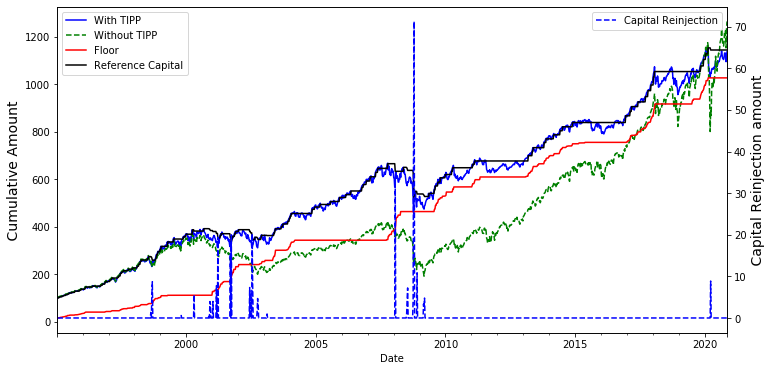

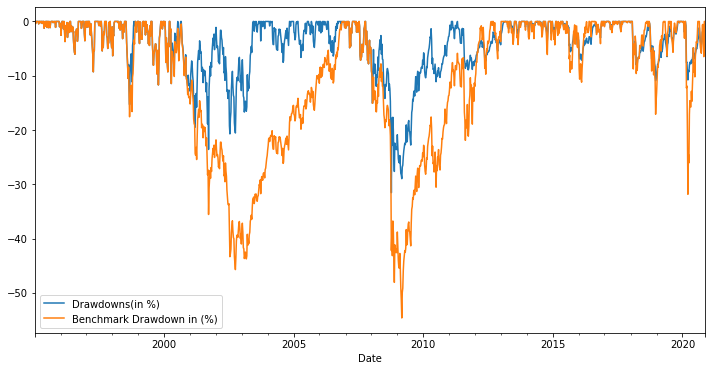

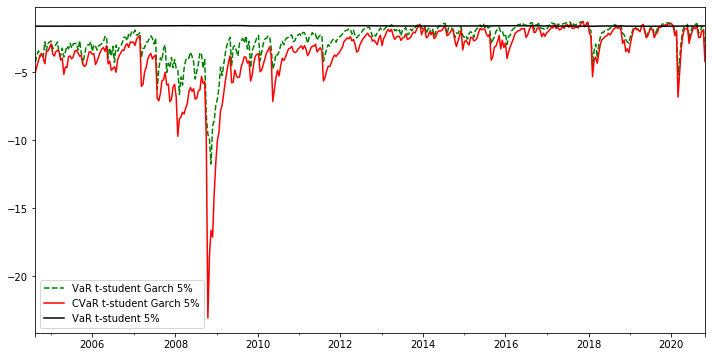

Please enter a new command('help' for a summary of the commands): exit
		 Sucess you are out


In [5]:
while True :
    user = input("Please enter a new command('help' for a summary of the commands): ")
    # guide him
    if user == "help":
        print("=" * 90 + "\nTo visualize a TPPI strategy using SP500 etf(SPY) type 1:\n"
              + "=" * 90 +"\nTo register a TPPI strategy Backtest using SP500 etf(SPY) on excel type 2:\n"
              +"=" * 90+"\nto leave the app, simply type 'exit'\n\n")

    elif user =="1": 
        print("Choose your risky asset :")
        
        ticker = str(input())
        
        Risk_ass,idx = Initializing_values().Risky_asset(ticker)
        
        rfree = Initializing_values().Risky_free_asset(idx)
        
        print("Choose a Lock in")
        
        Lock_in = float(input())
        
        print("Choose a multiplier")
        
        m = float(input())
        
        print("Choose a floor")
        
        floor_percent = float(input())
        
        print("Choose a minimum risk capital rate to allocate ")
        
        Min_risk_part = float(input())
        
        print("Choose a Capital reinjection threshold ")
        
        Capital_reinjection_rate = float(input())
        
        print("Choose an amount to allocate")
        
        tipp = float(input())
        
        TIPP_values, floor_values,Capital_reinjection,reference_cap = Initializing_values().Values(Risk_ass,rfree,Lock_in,Min_risk_part,Capital_reinjection_rate,tipp,floor_percent,m)
        
        returns = TIPP_values.pct_change()
        #Initializing_values().Charted(sp500,CPPI_values, floor_values,Capital_reinjection,reference_cap)
        
        Omega_r = Initializing_values().Omega_ratio(returns)
        
        Sharp_ratio =  Initializing_values().Sharp_rt(returns,rfree,days=52)
        
        Sortino_ratio =  Initializing_values().Sortino_rt(returns,rfree,days=52)
        
        information_ratio =  Initializing_values().information_ratio(returns,Risk_ass,days=52)
        
        M2_Ratio =  Initializing_values().modigliani_ratio(returns,Risk_ass,rfree,days=52)
        
        PSR =  Initializing_values().probabilistic_sharpe_ratio(returns,Risk_ass,rfree,days=52)
        
        STD = Initializing_values().STD(returns,days=52)
        
        CGR = Initializing_values().CAGR(returns)
        
        Actualized_Var,Actualized_Expected_Shortfall,Cst_VaR =  Initializing_values().VaR_Studen_Distribution(returns,theta=0.05,sampled_garch_number_needed=500)
        
        Beta,jensen_alpha= Initializing_values().jensen_alpha_beta(returns ,Risk_ass,days=52)
        
        Max_Drawdown = Initializing_values().DD(returns).min()[0]
        
        cumulative_returns = Initializing_values().Cumulative_r(returns)
        
        print('Sharpe Ratio :',Sharp_ratio)
        
        print('--'*10)
        
        print('Sortino Ratio :',Sortino_ratio)
        
        print('--'*10)
        
        print('Information Ratio :',information_ratio)
        
        print('--'*10)
        
        print('Modigliani Ratio :',M2_Ratio)
        
        print('--'*10)
        
        print('Probabilistic Sharpe ratio (in %) :',PSR*100)
        
        print('--'*10)
        
        print('CAGR (in %) :',CGR*100)
        
        print('--'*10)
        
        print('Standard Deviation :',STD)
        
        print('--'*10)
        
        print('Conditional t-student Garch VaR 95%(in %):',Actualized_Var.iloc[-1,0])
        
        print('--'*10)
        
        print('Conditional t-student Garch CVaR 95%(in %):',Actualized_Expected_Shortfall.iloc[-1,0])
        
        print('--'*10)
        
        print('Unconditional VaR 95%(in %) :',Cst_VaR.iloc[-1,0])
        
        print('--'*10)
        
        print('Beta :',Beta)
        
        print('--'*10)
        
        print('Jensen alpha :',jensen_alpha)
        
        print('--'*10)
        
        print('Omega Ratio :',Omega_r)
        
        print('--'*10)
        
        print('Maximum Drawdown(in %) :',Max_Drawdown)
        
        print('--'*10)
        
        print('Cumulative returns(in %):',cumulative_returns*100)
        
        
        Initializing_values().Charted(Risk_ass,TIPP_values, floor_values,Capital_reinjection,reference_cap,Actualized_Var,Actualized_Expected_Shortfall,Cst_VaR)
        
            
    elif user == "2":
        
        print("Choose your risky asset :")
        
        ticker = str(input())
        
        Risk_ass,idx = Initializing_values().Risky_asset(ticker)
        
        rfree = Initializing_values().Risky_free_asset(idx)
        
        print("Choose a Lock in")
        
        Lock_in = float(input())
        
        print("Choose a multiplier")
        
        m = float(input())
        
        print("Choose a floor")
        
        floor_percent = float(input())
        
        print("Choose a minimum risk capital rate to allocate ")
        
        Min_risk_part = float(input())
        
        print("Choose a Capital reinjection rate ")
        
        Capital_reinjection_rate = float(input())
        
        print("Choose an amount to allocate(in M$)")
        
        tipp = float(input())
        
        TIPP_values, floor_values,Capital_reinjection,reference_cap = Initializing_values().Values(Risk_ass,rfree,Lock_in,Min_risk_part,Capital_reinjection_rate,tipp,floor_percent,m)
        
        print("The document will be registered on excel.Please wait for the confirmation")
        
        Initializing_values().Rgstr(Risk_ass,TIPP_values, floor_values,Capital_reinjection,reference_cap,rfree,52,0.05,500)
        
        
    elif user == "exit":
        print("\t\t Sucess you are out")
        break
            
    else:
        print('You typed on a wrong command.Please retry')  
    